# QSVC (into the details)

$\blacktriangleright$ This is part **III** of a notebook series demonstrating the functionality of the <code>QMLab</code>-Package. 

[Click here to get to Part 1](./classical_learning.ipynb) &nbsp; or &nbsp; 
[Part 3](./training_quantum_kernels.ipynb).

Now let's look into the details of what happened in [Part 2](02_quantum_advantage.ipynb).

The entire progress of computing the gram matrix can be outsourced to a quantum computer. 

The rest of the support vector algorithm stays exactly the same - resulting in a hybrid algorithm.

It's called a **Q**uantum **S**upport **V**ector **C**lassifier - <code>QSVC</code> for short.

First we needed an **data embedding** that maps our data vectors into a Hilbert space $\mathcal{H}$, the space where state vectors $\Ket{\psi}$ exist.

An data embedding is a feature map of the form  
$$ 
\mathbf{x} \in \mathbb{R}^d \longrightarrow \Ket{\psi(\mathbf{x})} \in \mathcal{H} \tag{1}
$$
where we obtain the state vector by applying a parameterized unitary to the ground state of a quantum circuit, i.e. 
$$
\mathcal{U}(\mathbf{x}) \Ket{0} = \Ket{\psi(\mathbf{x})}.\tag{2} $$

We can obtain two different quantum states by parameterizing them with different data vectors and measure their fidelity:
$$
\hat{K}_{ij} = \left| \Braket{\psi(\boldsymbol{x}_j) | \psi(\boldsymbol{x}_i)}\right|^2 \quad i, j \in \{1, \ldots, n\} 
\tag{3}
$$
where $n$ is number of training examples.

We prepare the state 
$$
\mathcal{U}^\dagger(\boldsymbol{x}_j) \; \mathcal{U}(\boldsymbol{x}_i) \Ket{0} 
$$

and measuring the probability of measuring a bitstring only consisting of zeros, i.e. 
$$
\hat{K}_{ij} = P(measure\Ket{0})
= \left| \Braket{0 | \mathcal{U}^\dagger(\mathbf{x}_j) \, \mathcal{U}(\boldsymbol{x}_i) | 0 } \right|^2 = \left| \Braket{\psi(\mathbf{x}_j) | \psi(\mathbf{x}_i)}\right|^2 
        .
$$

In [13]:
import numpy as np
from sklearn import metrics
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qmlab.kernel import FidelityQuantumKernel
from qmlab.preprocessing import (
    parse_biomed_data_to_ndarray,
    parse_biomed_data_to_df,
    scale_to_specified_interval,
)
from qmlab.plotting import (
    set_plot_style,
    plot_kernel_heatmap,
)
import plotly.express as px

random_state = 12345
np.random.seed(random_state)
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
set_plot_style("dark_background")

In [14]:
X, y, _ = parse_biomed_data_to_ndarray("haberman_new")
X = scale_to_specified_interval(X, interval=(-np.pi / 2, np.pi / 2))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [28]:
df = parse_biomed_data_to_df("haberman_new")
fig = px.scatter_3d(
    df,
    x="V2",
    y="V3",
    z="V4",
    color="V1",
    size_max=18,
    template="plotly_dark",
    color_discrete_map="seaborn"
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

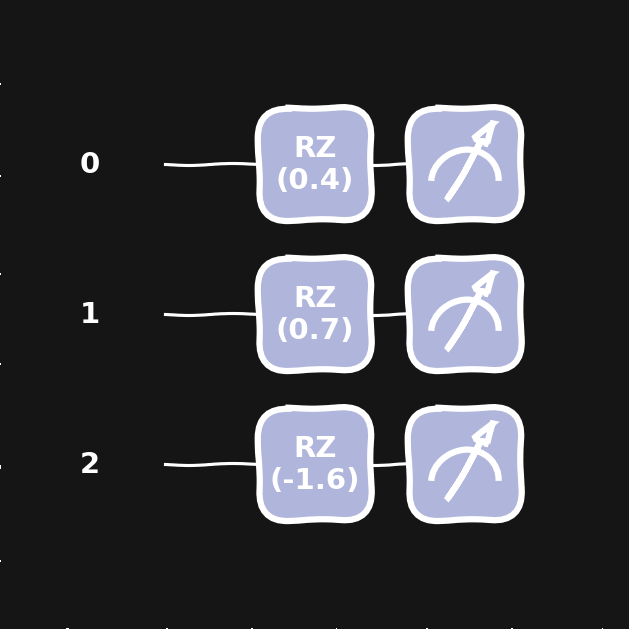

In [31]:
from sklearn.svm import SVC
import pennylane as qml

num_features = X_train.shape[1]
dev = qml.device("default.qubit", wires=num_features)

@qml.qnode(dev)
def angle(x: NDArray) -> qml.QNode:
    qml.AngleEmbedding(x, rotation="Z", wires=range(num_features))
    return qml.state()

fig, ax = qml.draw_mpl(
    angle, style="sketch_dark", show_all_wires=True, level=None, decimals=1
)(X_train[0])

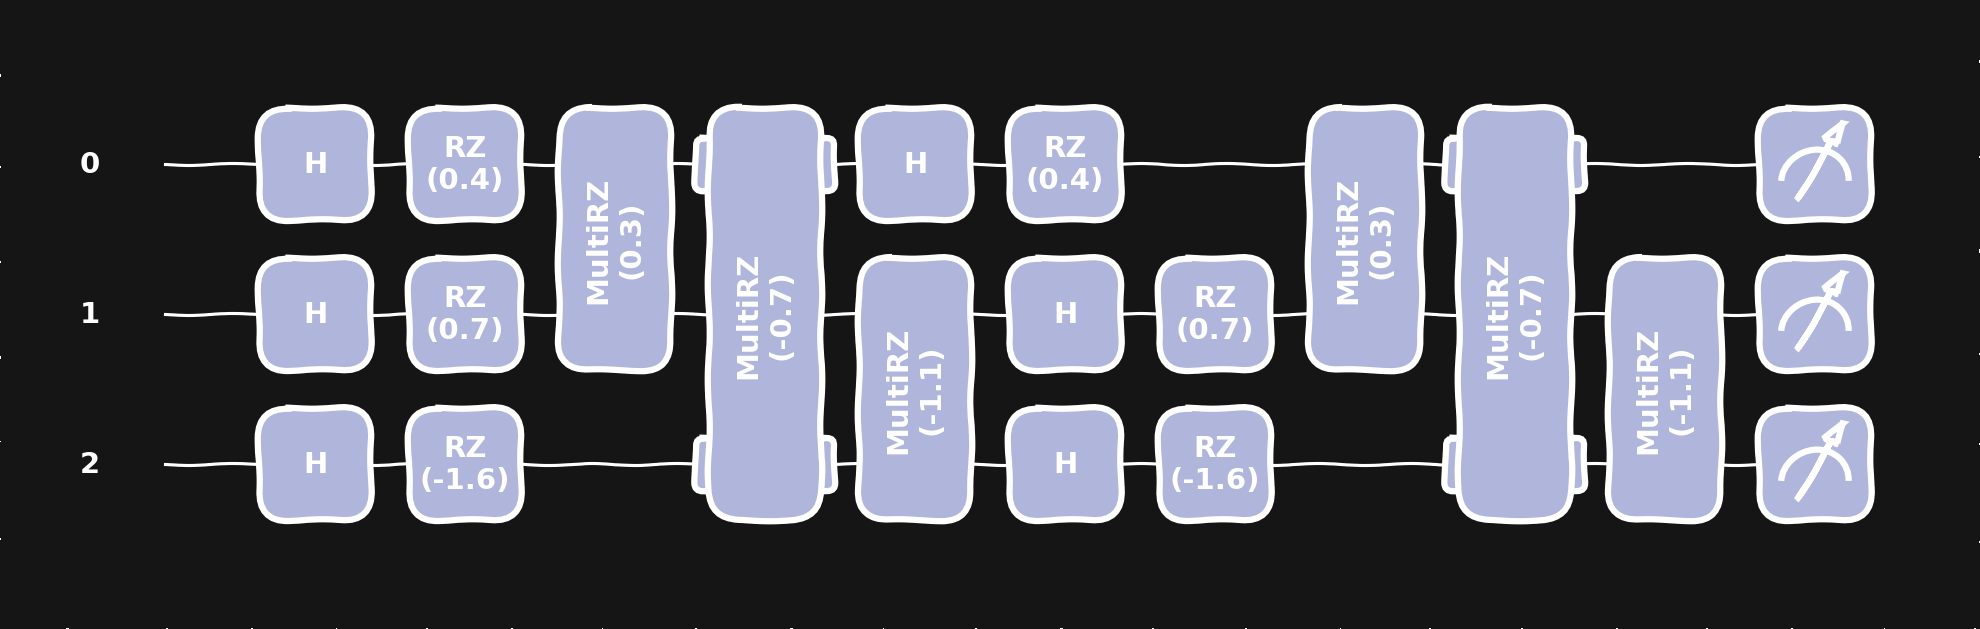

In [29]:
@qml.qnode(dev)
def iqp(x: NDArray) -> qml.QNode:
    qml.IQPEmbedding(x, n_repeats=2, wires=range(num_features))
    return qml.state()

fig, ax = qml.draw_mpl(
    iqp, style="sketch_dark", show_all_wires=True, level=None, decimals=1
)(X_train[0])

Let's use the <code>FidelityQuantumKernel</code>-class to obtain the kernel matrix:

In [17]:
quantum_kernel = FidelityQuantumKernel(data_embedding="IQP", jit=True, reps=2)

quantum_kernel.initialize_params(feature_dimension=X_train.shape[1])
kernel_train = quantum_kernel.evaluate(X_train, X_train)
kernel_test = quantum_kernel.evaluate(X_test, X_train)

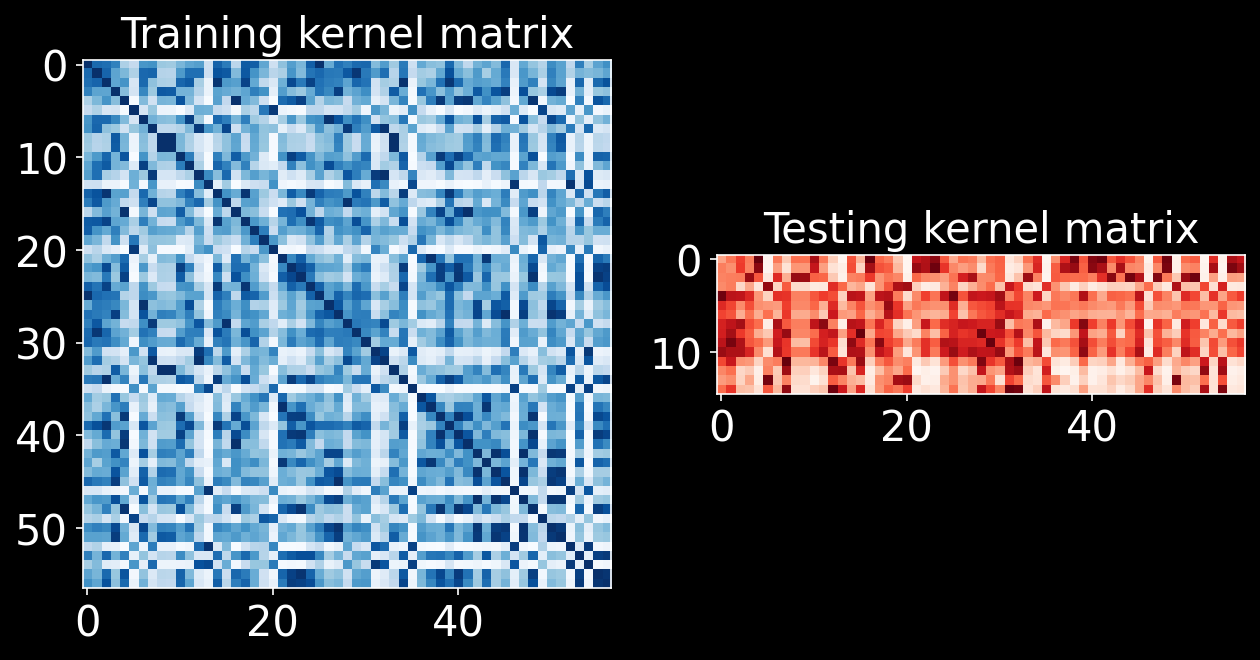

In [18]:
plot_kernel_heatmap(kernel_train, kernel_test)

In [19]:
precomputed_kernel_svc = SVC(kernel="precomputed", random_state=random_state)
precomputed_kernel_svc.fit(kernel_train, y_train)
precomputed_quantum_kernel_score = precomputed_kernel_svc.score(kernel_test, y_test)
print(f"Precomputed kernel classification score: {precomputed_quantum_kernel_score}")

Precomputed kernel classification score: 1.0


In [23]:
y_pred = precomputed_kernel_svc.predict(kernel_test)
acc = metrics.balanced_accuracy_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)
print("Prediction scores: \n")
print(f"Accuracy:\t{acc:.2f}")
print(f" ROC_AUC:\t{roc_auc:.2f}")

Prediction scores: 

Accuracy:	1.00
 ROC_AUC:	1.00
